## Import Package

In [1]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=9bf111d268d08c1c27c644fb9f9abaf75a61b03c95b836ddae8e3f3a7c49a2ff
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [2]:
!pip install SQLAlchemy==1.4.46

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.19
    Uninstalling SQLAlchemy-2.0.19:
      Successfully uninstalled SQLAlchemy-2.0.19


In [3]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandasql as ps
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
%matplotlib inline


## Data Understanding

### Load dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# dataframe = pd.read_excel('/content/drive/MyDrive/tugas dibimbing/Extra Class 7/Online Retail.xlsx')

# dataframe.to_csv('/content/drive/MyDrive/tugas dibimbing/Extra Class 7/Online Retail.csv', index=False, encoding='utf-8')

In [6]:
data = pd.read_csv('/content/drive/MyDrive/tugas dibimbing/Extra Class 7/Online Retail.csv')
retail=data.copy()
retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


### Data information

In [ ]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


* dataset terdiri dari 541909 baris dan 8 kolom
* Terlihat ada missing values di beberapa kolom. Untuk  tipe data tidak ada yang bermasalah kecuali di InvoiceDate yang seharusnya bertipe datetime

### Statistical Summary

In [ ]:
# membagi nama kolom berdasarkan tipe datanya
numericals = retail.select_dtypes(include=['int64','float64']).columns.tolist()
categoricals = retail.select_dtypes(exclude=['int64','float64']).columns.tolist()

print(f"numericals columns are {numericals}")
print(f"categoricals columns are {categoricals}")

numericals columns are ['Quantity', 'UnitPrice', 'CustomerID']
categoricals columns are ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']


In [ ]:
categoricals = ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']

numericals = ['Quantity', 'UnitPrice', 'CustomerID']

#### numerical statistical summary

In [ ]:
# numerical statistical summary
retail[numericals].describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Observations:

* mean > median di kolom `Quantity` dan `UnitPrice` mengindikasikan distribusi skew.
* kolom Quantity dan UnitPrice memiliki nilai minus yang tidak wajar
* kolom quantity memiliki rentang yang besar antara minimum dan maximum. Dapat mengindikasikan ketidakseimbangan antara permintaan pelanggan dan kemampuan perusahaan untuk memenuhi permintaan tersebut. ataupun bisa disebabkan oleh hal lain.Kita akan lakukan validasi.
* Rentang yang sangat besar antara nilai minimum dan maksimum dalam kolom unitprice menunjukkan adanya variasi harga yang signifikan di produk atau layanan perusahaan. Dapat menunjukkan adanya masalah dalam proses penetapan harga. Misalnya, harga yang sangat rendah mungkin mengindikasikan adanya diskon yang berlebihan atau penurunan harga yang tidak diinginkan. Bisa juga disebabkan oleh hal-hal lain. Kita akan lakukan validasi

<!-- * A mean > median in passenger_count and trip_duration indicates a positively skewed distribution.
* `pickup_longitude`, `pickup_latitude`,`dropoff_longitude`,`dropoff_latitude` exhibit a normal distribution as the gap between the mean and median is less than 10%. -->





##### Data validation-Numerical

In [ ]:
retail[retail['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [ ]:
filtered_data = retail[retail['InvoiceNo'].str.contains('C', case=False)]

In [ ]:
filtered_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


Data Quantity yang minus ternyata berasal dari InvoiceNo yang diawali dengan huruf C yang berarti disebabkan oleh adanya pesanan yang di cancel oleh customer.



In [ ]:
retail[retail['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [ ]:
retail[retail['StockCode']=='B']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Setelah kita lihat,ternyata  UnitPrice yang minus berasal dari StockCode 'B' dan dengan deskripsi 'Adjust bad debt' yang terdiri hanya dari 3 baris dimana salah satu kolomnya tidak minus

Untuk menghapus kolom yang terdapat **minus di UnitPrice**, kita akan menghapus kolom StockCode yang berkode 'B' dimana hanya terdapat 3 baris. Selain itu kita harus menghapusnya karena nilai dari CustomerID dari StockCode yang mengandung 'B' adalah Nan

In [ ]:
retail=retail.drop(retail[retail['StockCode']=='B'].index).reset_index(drop=True)

In [ ]:
retail.shape

(541906, 8)

#### categorical statistical summary

In [ ]:
# describe method on categorical data
retail[categoricals].describe()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541906,541906,540452,541906,541906
unique,25897,4069,4222,23258,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,United Kingdom
freq,1114,2313,2369,1114,495475


Observations:

<!-- * The top pickup date is 2016-04-05  (5 rows).
* The top dropoff date is 2016-02-19 (5 rows).
* The majority of store and forward flags are N, indicating that on average, trip records are not stored in the vehicle's memory before being sent to the vendor (1450592). -->

* InvoiceNo yang paling top adalah 573585 (1114 rows)
* StockCode yang paling populer adalah 85123A (2270 rows)
* Description / product yang paling populer adalah WHITE HANGING HEART T-LIGHT HOLDER	(2327)
* InvoiceDate yang paling banyak adalah 2011-10-31 (1114 rows)
* Country dari customer yang populer adalah United Kingdom (486283)

<!-- * The majority of customers are female (5545 rows).
* The most preferred shipping method by customers is `Ship` compared to other shipping methods (7462 rows).
* The warehouse block with the highest frequency is block F (3666 rows).
* The most common product importance category is "low" (5297 rows). -->


### Drop missing value

In [ ]:
retail.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135077
Country             0
dtype: int64

In [ ]:
retail=retail.dropna()

In [ ]:
retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Drop duplicates

In [ ]:
retail.duplicated().sum()

5225

In [ ]:
retail = retail.drop_duplicates()

In [ ]:
retail.duplicated().sum()

0

### Preprocessing

1. Ubah tipe data InvoiceDate menjadi datetime

In [ ]:
retail['InvoiceDate']=pd.to_datetime(retail['InvoiceDate'])

## Build RFM

### Recency

In [ ]:
present_day = retail['InvoiceDate'].max()+ datetime.timedelta(days=3)

In [ ]:
print('Present Day :',present_day)

Present Day : 2011-12-12 12:50:00


In [ ]:
# Menambahkan kolom "recency" baru ke DataFrame
# retail = retail.merge(recency, on='CustomerID')

In [ ]:
recency= retail.groupby('CustomerID').agg({'InvoiceDate':lambda date:(present_day - date.max()).days
                                         }).reset_index()
recency=recency.rename(columns={'InvoiceDate':'recency'})
recency.head()

,CustomerID,recency
0,12346.0,328
1,12347.0,4
2,12348.0,77
3,12349.0,21
4,12350.0,312


In [ ]:
recency

,CustomerID,recency
0,12346.0,328
1,12347.0,4
2,12348.0,77
3,12349.0,21
4,12350.0,312
...,...,...
4367,18280.0,280
4368,18281.0,183
4369,18282.0,10
4370,18283.0,6


### Frequency + Monetary

In [ ]:
def dataset():

    q='''
        select
                  do.CustomerID,
                  COUNT(DISTINCT CASE WHEN LOWER(InvoiceNo) NOT LIKE '%C%' THEN InvoiceNo END) AS Frequency_Order,
                  COUNT(DISTINCT CASE WHEN LOWER(InvoiceNo) LIKE '%C%' THEN InvoiceNo END) AS Frequency_Cancel,
                  SUM(CASE WHEN Quantity >= 0 THEN Quantity * UnitPrice ELSE 0 END) AS monetary
              from retail do
              group by 1
              order by Frequency_Cancel desc
    '''
    return q

dataset = ps.sqldf(dataset())
dataset.head(3)

,CustomerID,Frequency_Order,Frequency_Cancel,monetary
0,14911.0,201,47,143711.17
1,17841.0,124,45,40519.84
2,14606.0,93,35,12076.15


In [ ]:
dataset = dataset.merge(recency, on='CustomerID', how='inner')
dataset.head(3)

,CustomerID,Frequency_Order,Frequency_Cancel,monetary,recency
0,14911.0,201,47,143711.17,3
1,17841.0,124,45,40519.84,4
2,14606.0,93,35,12076.15,3


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        4372 non-null   float64
 1   Frequency_Order   4372 non-null   int64  
 2   Frequency_Cancel  4372 non-null   int64  
 3   monetary          4372 non-null   float64
 4   recency           4372 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 204.9 KB


## Modeling and Evaluation

### Scaling

In [ ]:
feat=['recency','Frequency_Order','Frequency_Cancel','monetary']
data_rfm=dataset[feat].copy()
data_rfm.head()

,recency,Frequency_Order,Frequency_Cancel,monetary
0,3,201,47,143711.17
1,4,124,45,40519.84
2,3,93,35,12076.15
3,5,55,31,8507.13
4,3,91,27,60632.75


In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(data_rfm)

In [ ]:
feats = list(data_rfm)
new_df = pd.DataFrame(data = X_std, columns = feats)
new_df.head()

,recency,Frequency_Order,Frequency_Cancel,monetary
0,-0.903658,25.605251,21.599015,15.828219
1,-0.893733,15.584914,20.663268,4.299752
2,-0.903658,11.550753,15.984534,1.122041
3,-0.883808,6.605652,14.113040,0.723313
4,-0.903658,11.290485,12.241546,6.546753


### Best K

<Axes: >

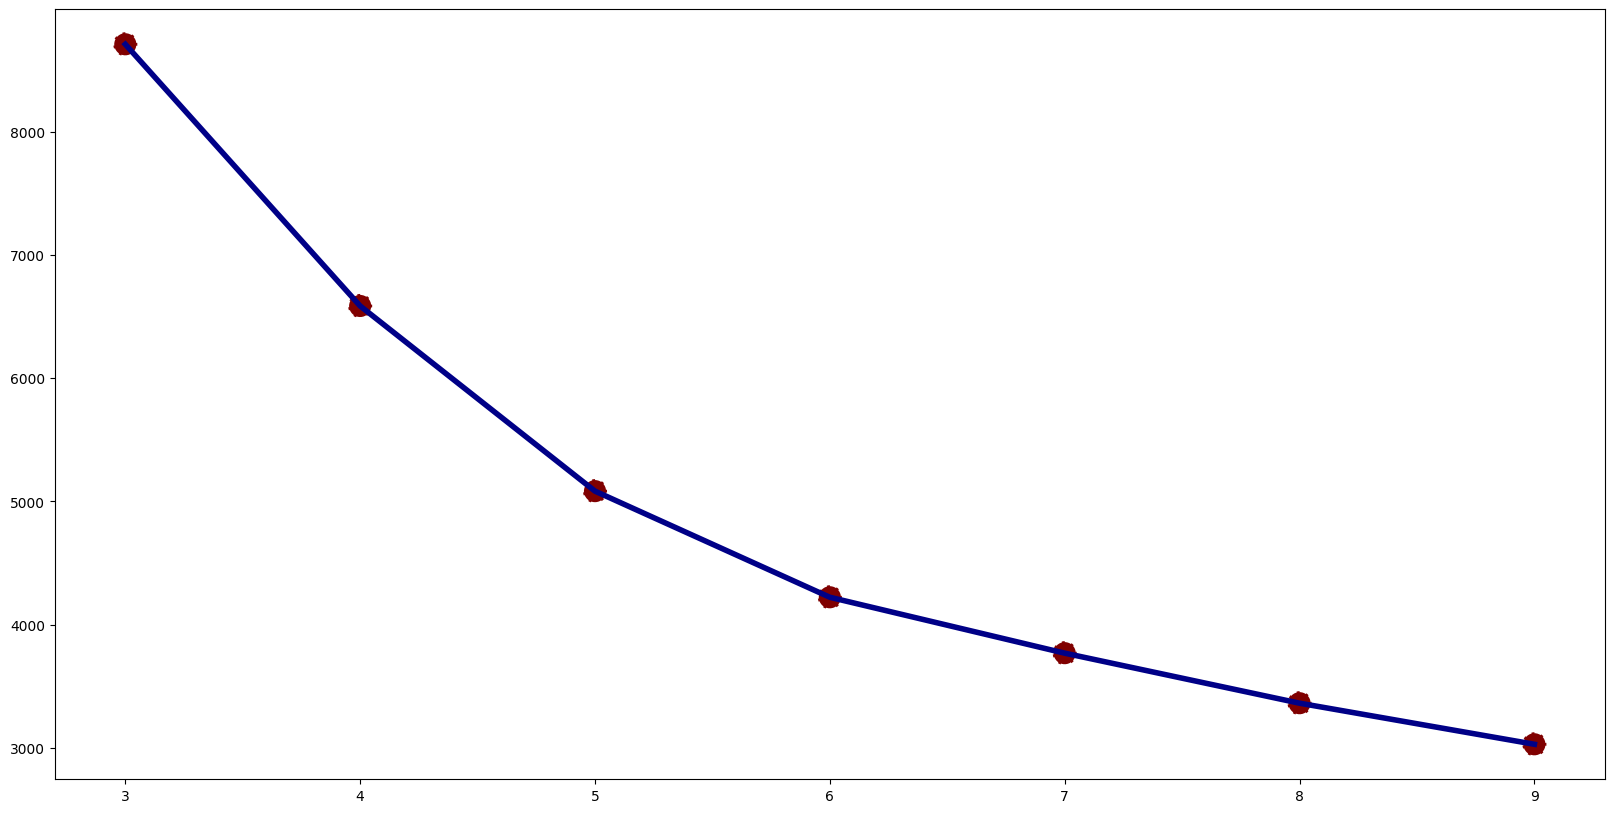

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(3, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(20, 10))

sns.lineplot(x=range(3, 10), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(3, 10), y=inertia, s=300, color='#800000',  linestyle='--')


In [ ]:
# from sklearn.metrics import silhouette_score

# range_n_clusters = list(range(3,10))
# print(range_n_clusters)

In [ ]:
# arr_silhouette_score_euclidean = []
# for i in range_n_clusters:
#     kmeans = KMeans(n_clusters=i).fit(X_std)
#     preds = kmeans.predict(new_df)

#     score_euclidean = silhouette_score(new_df, preds, metric='euclidean')
#     arr_silhouette_score_euclidean.append(score_euclidean)

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(15, 6))
# sns.lineplot(x=range(3,10), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4, ax=ax[0])
# sns.scatterplot(x=range(3,10), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--',ax=ax[0])

# sns.lineplot(x=range(3, 10), y=inertia, color='#000087', linewidth = 4,ax=ax[1])
# sns.scatterplot(x=range(3, 10), y=inertia, s=300, color='#800000',  linestyle='--', ax=ax[1])

### Clustering

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X_std)

KMeans(n_clusters=5, random_state=0)

In [ ]:
data_rfm['clusters'] = kmeans.labels_
data_rfm.head()

,recency,Frequency_Order,Frequency_Cancel,monetary,clusters
0,3,201,47,143711.17,1
1,4,124,45,40519.84,1
2,3,93,35,12076.15,1
3,5,55,31,8507.13,1
4,3,91,27,60632.75,1


In [ ]:
perc = [0.1,0.2,0.3,00.4,0.5,0.6,0.7,0.8,0.9]
data_rfm.describe(percentiles=perc)

,recency,Frequency_Order,Frequency_Cancel,monetary,clusters
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,94.047118,4.239707,0.835773,2032.755923,1.119854
std,100.765435,7.685252,2.137575,8952.025481,1.718538
min,3.000000,0.000000,0.000000,0.000000,0.000000
10%,7.000000,1.000000,0.000000,151.307000,0.000000
20%,13.000000,1.000000,0.000000,241.196000,0.000000
30%,24.000000,1.000000,0.000000,344.042000,0.000000
40%,34.000000,2.000000,0.000000,480.790000,0.000000
50%,52.000000,2.000000,0.000000,659.435000,0.000000
60%,73.000000,3.000000,0.000000,923.772000,0.000000


In [ ]:
data_rfm.groupby('clusters').agg({
                            'recency' : ['mean'],
                            'Frequency_Order' : ['mean'],
                            'Frequency_Cancel' : ['mean'],
                            'monetary' : ['mean']

})

,recency,Frequency_Order,Frequency_Cancel,monetary
,mean,mean,mean,mean
clusters,,,,
0,45.463618,3.563084,0.524366,1297.751944
1,9.000000,104.700000,27.600000,50091.459000
2,17.685315,17.293706,5.101399,9575.720105
3,9.666667,43.000000,5.166667,190808.536667
4,251.172253,1.499069,0.295158,572.367142


In [ ]:
# 0 : customer need attention
# 1 : potential loyal customer
# 2 : reguler customer
# 3 : loyal customer
# 4 : potential lost customer

In [ ]:
data_rfm.head(3)

,recency,Frequency_Order,Frequency_Cancel,monetary,clusters
0,3,201,47,143711.17,1
1,4,124,45,40519.84,1
2,3,93,35,12076.15,1


### Clustering Visualization - PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(X_std)
pcs = pca.transform(X_std)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = data_rfm['clusters']
data_pca.head()

,PC 1,PC 2,clusters
0,35.750466,8.342693,1
1,23.476769,4.071599,1
2,16.836367,2.271824,1
3,12.558435,1.538526,1
4,17.215641,3.383851,1


<Axes: xlabel='PC 1', ylabel='PC 2'>

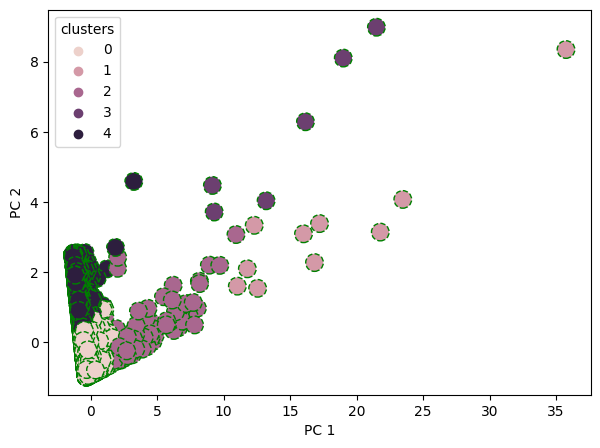

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=data_pca,
    s=160,
    ax=ax
)

### Clustering Visualization - Tsne

In [ ]:
from sklearn.manifold import TSNE

Xtsne = TSNE(n_components=2).fit_transform(X_std)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne['clusters'] = data_rfm['clusters']
dftsne.head()

,x1,x2,clusters
0,55.011051,-16.917471,1
1,55.520111,-16.869854,1
2,55.856697,-16.738926,1
3,56.425522,-16.614262,1
4,55.510281,-16.387733,1


<Axes: xlabel='x1', ylabel='x2'>

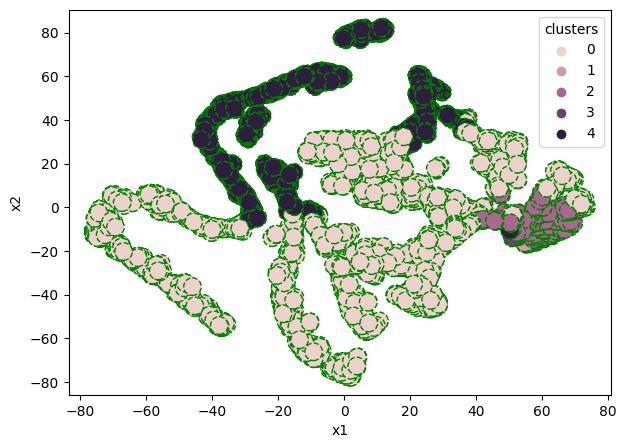

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

sns.scatterplot(
    x="x1", y="x2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=dftsne,
    s=160,
    ax=ax
)